# Goal

## 1.) Implement Integrated Gradients
    a.) Using two versions of Integrated Gradients. The first is a custom implementation adapted from the Authors code provided on their github
    b.) The second is a implementation developed by Naozumi Hiranuma (hiranumn@uw.edu) 
## 2.) Update model to Keras 2.0
    a.) Successfully transferred model to newest keras version
    
## 3.) Queried Gdelt using all business news not just US

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Michael Di Amore
"""

#Had to use python 2 for TF 1.4.0 was having problems with my virutal env
from __future__ import print_function
from __future__ import division

%matplotlib inline
import tensorflow as tf
import Query as query
import quandl 
import numpy as np
# np.random.seed(12345) # Set seed

import pandas as pd
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt

import tensorflow as tf
import edward as ed

import keras
import tensorflow.contrib.keras as k


Using TensorFlow backend.


In [2]:
####
#  Load Data. If you don't want to / can't run the query.
# Basically this is all data from 2007-01-01 to 2017-10-06
load_data = True
if load_data == True:
    print ('Loading Data...')
    
    df_2000_2006 = pd.read_csv('Gdelt_events_20000101_20061231.csv')
    df_2000_2006 = df_2000_2006.set_index('sqldate',drop=True).sort_index()
    df_2007_2009 = pd.read_csv('Gdelt_events_20070101_20091231_BUS_ALL.csv')
    df_2007_2009 = df_2007_2009.set_index('sqldate',drop=True).sort_index()
    df_2010_2011 = pd.read_csv('Gdelt_events_20100101_20111231_BUS_ALL.csv')
    df_2010_2011 = df_2010_2011.set_index('sqldate',drop=True).sort_index()
    df_2012_2013 = pd.read_csv('Gdelt_events_20120101_20131231_BUS_ALL.csv')
    df_2012_2013 = df_2012_2013.set_index('sqldate',drop=True).sort_index()
    df_201401_201406 = pd.read_csv('Gdelt_events_20140101_20140631_BUS_ALL.csv')
    df_201401_201406 = df_201401_201406.set_index('sqldate',drop=True).sort_index()
    df_201407_201501 = pd.read_csv('Gdelt_events_20140701_20150101_BUS_ALL.csv')
    df_201407_201501 = df_201407_201501.set_index('sqldate',drop=True).sort_index()
    df_201502_201506 = pd.read_csv('Gdelt_events_20150102_20150601_BUS_ALL.csv')
    df_201502_201506 = df_201502_201506.set_index('sqldate',drop=True).sort_index()
    df_201506_201512 = pd.read_csv('Gdelt_events_20150602_20151231_BUS_ALL.csv')
    df_201506_201512 = df_201506_201512.set_index('sqldate',drop=True).sort_index()
    df_201601_201606 = pd.read_csv('Gdelt_events_20160101_20160631_BUS_ALL.csv')
    df_201601_201606 = df_201601_201606.set_index('sqldate',drop=True).sort_index()
    df_201607_201612 = pd.read_csv('Gdelt_events_20160701_20161231_BUS_ALL.csv')
    df_201607_201612 = df_201607_201612.set_index('sqldate',drop=True).sort_index()
    df_201701_201710 = pd.read_csv('Gdelt_events_20170101_20171006_BUS_ALL.csv')
    df_201701_201710 = df_201701_201710.set_index('sqldate',drop=True).sort_index()

    
    
    gdelt_df = pd.concat([df_2000_2006,df_2007_2009,df_2010_2011,df_2012_2013,df_201401_201406,df_201407_201501,
                          df_201502_201506,df_201601_201606,df_201607_201612,df_201701_201710])
    
    del df_2000_2006,df_2007_2009,df_2010_2011,df_2012_2013,df_201401_201406,df_201407_201501
    del df_201502_201506,df_201601_201606,df_201607_201612,df_201701_201710
####

Loading Data...


In [4]:
# Set Params
lookback_window = int(np.round(252/2))
number_stdev = 3.5

proj_id = 'capstone-v0'
start_date = '2000-01-01'
end_date = '2017-10-06'
ticker = '^GSPC'
my_query = query.query_tool(proj_id,start_date,end_date,ticker)
sql_query = """
            SELECT Actor1Name, GoldsteinScale,NumMentions,sourceurl,
            sqldate, avgtone, numarticles, numsources,  
            FROM [gdelt-bq:full.events] 
            WHERE sqldate > 20010101 and sqldate <= 20061231  and 
            Actor1Code like '%BUS% "
            """
if load_data == False:
    print ('Querying Gdelt...')
    my_query.query_gdelt(sql_query)
    my_query.gdelt_df = my_query.gdelt_df.set_index('sqldate',drop=True).sort_index()
    df = my_query.gdelt_df.copy(True)

#Creating Labels. i.e. if change in spx_return is x standard deviations
security_prices = my_query.query_yahoo()
security_return_for_df = np.log(security_prices['Adj Close']).diff() #log Return
security_return = np.log(security_prices['Adj Close']).diff() #log Return
security_vol = security_return.rolling(window=lookback_window).std().dropna()
security_mean = security_return.rolling(window=lookback_window).mean().dropna()
security_vol.name = 'Volatility'
security_return = security_return.loc[security_vol.index] #First entry is NAN because of return
# day_over_day_diff = np.abs(security_return.diff())#can subtract because of log returns
# event_idx = [(np.abs(security_mean)+(security_vol * 3.5)) < np.abs(security_return)]
event_idx = [((security_mean + security_vol * number_stdev) < security_return) | ((security_mean - security_vol *number_stdev) > security_return) ]
event_idx = np.array(event_idx).astype(int).flatten()
event_idx = pd.Series(event_idx,index=security_return.index)
print ('Data Loaded')

Data Loaded


In [5]:
api_key = pd.read_table('api_key.txt',header=None)
api_key =  api_key[0][0]
wti_co = my_query.query_quandl("FRED/DCOILWTICO",api_key)
unemploy = my_query.query_quandl("FRED/UNEMPLOY",api_key)
m1v = my_query.query_quandl("FRED/M1V",api_key)
m2v = my_query.query_quandl("FRED/M2V",api_key)
stressindex = my_query.query_quandl("FRED/STLFSI", api_key)
dff = my_query.query_quandl("FRED/DFF",api_key)
my_query.set_ticker('^VIX')
vix = my_query.query_yahoo()
vix = vix['Adj Close']
vix.name = 'VIX'
print ('Quandl Loaded')

Quandl Loaded


In [6]:
quandl_others = pd.concat([wti_co,unemploy,m1v,m2v,stressindex,vix,dff],axis=1)
quandl_others.columns = ['wti_co','unemploy','m1v','m2v','slsi','vix','dff']
quandl_others.ffill(inplace=True)
quandl_others.fillna(0,inplace=True)

In [7]:
def normalize_ts(series,lookback=lookback_window):
    rolling_mean = series.rolling(window=lookback).mean()
    rolling_std = series.rolling(window=lookback).std() + .10**3
    normalized = (series-rolling_mean)/rolling_std
    normalized = normalized.dropna()
    return(normalized)

In [8]:
def weight_gdelt(series,num_articles):
    if series.name != 'numarticles':
        return(series/num_articles)
    else:
        return (num_articles)

In [9]:
#Collapse numerical data into x,y pairs by taking means
# collapsed = gdelt_df[['GoldsteinScale','numarticles','NumMentions','avgtone','numsources']]
# collapsed = collapsed.apply(lambda x: weight_gdelt(x,gdelt_df['numarticles']))
collapsed = gdelt_df.groupby(by=gdelt_df.index).mean()

#Shift data so as only to use yesterday's news for tomorrow's prediction
#i.e. we shift forward, using yesterday data as today
collapsed_shifted = collapsed.shift(1)
quandl_shifted = quandl_others.shift(1)
# spy_shifted = pd.DataFrame(security_prices).shift(1)

#Scale the data in such a way that we aren't looking forward into the feature
print ('Scaling using custom scaler')
collapsed_shifted = collapsed_shifted.apply(normalize_ts)
quandl_shifted = quandl_shifted.apply(normalize_ts)
# spy_shifted = spy_shifted.apply(normalize_ts)

collapsed_shifted.index = pd.to_datetime(collapsed_shifted.index,format='%Y%m%d')
collapsed_shifted = collapsed_shifted.loc[security_vol.index].dropna()
collapsed_shifted = pd.concat([collapsed_shifted,quandl_shifted],axis=1)
event_idx = event_idx.dropna()


# collapsed_shifted = quandl_shifted
collapsed_shifted = collapsed_shifted.loc[event_idx.index][1:] 
event_idx = event_idx[1:]

Scaling using custom scaler


In [10]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)
Y_test_df = Y_test.copy(True)
X_train  = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Creating train test split...


In [11]:

# pca = PCA(whiten=True)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# X_val = pca.transform(X_val)

print ('Length of X_train before smote')
print (len(X_train))
print ('Number of Positives before smote')
print (Y_train.sum())


print ('Performing Oversampling/Undersampling...')
s = SMOTEENN()
X_train,Y_train= s.fit_sample(X_train,Y_train)

print ('Length of X_train after smote')
print (len(X_train))

print ('Number of Positive samples after smote')
print (Y_train.sum())

# print ('Proportion after smote {}'.format(sum(Y_train)/len(Y_train))


# X_train = X_train.reshape(-1,X_train.shape[1],1)
# X_test = X_test.reshape(-1,X_test.shape[1],1)
# X_val = X_val.reshape(-1,X_val.shape[1],1)
# print ('Done!')

Length of X_train before smote
2779
Number of Positives before smote
11
Performing Oversampling/Undersampling...
Length of X_train after smote
5481
Number of Positive samples after smote
2768


In [12]:
X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
D = X_train.shape[1]
Y_val = np.array(Y_val)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_train = Y_train.astype(np.int32)
Y_val = Y_val.astype(np.int32)
features = {'x':X_train}
drop_rate = .55


Y_train = Y_train.reshape(-1,1).flatten()
Y_val = Y_val.reshape(-1,1).flatten()
Y_test = np.array(Y_test).reshape(-1,1).flatten()
nh1 = 512
nh2 = 256
nh3 = 128

In [13]:
# def tf_model(features,labels,mode): 
tf.reset_default_graph()
data = tf.placeholder(dtype=tf.float32,shape=[None,D,1])
labels = tf.placeholder(dtype=tf.float32,shape=[None,1])
is_training = tf.placeholder(tf.bool)

## Keras Model - 2.0


In [14]:
from keras.layers import Conv1D,Dropout,BatchNormalization,Input,Flatten,MaxoutDense,Dense
from keras.constraints import maxnorm
from keras import backend as K

In [15]:
from keras.constraints import maxnorm
from keras.legacy.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.models import Model


def simple_keras_model(original):
    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    
    original_input = Input(shape=(original.shape[1],1),name='orig')
    layer1 =  Conv1D(nh1, 5, padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(original_input)
    layer1 = BatchNormalization()(layer1)
    layer1 = Dropout(.55)(layer1)
    
    layer2 = Conv1D(nh1,5,padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(layer1)
    layer2 = BatchNormalization()(layer2)
    layer2 = Dropout(.55)(layer2)
    
    layer3 = Conv1D(nh2,5,padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(layer2)
    layer3 = BatchNormalization()(layer3)
    layer3 = Dropout(.55)(layer3)

    layer4 = Conv1D(nh3,5,padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(layer3)
    layer4 = BatchNormalization()(layer4)
    layer4 = Dropout(.55)(layer4)
    
    
    layer5 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer4)
    layer5 = BatchNormalization()(layer5)
    layer5 = Dropout(.35)(layer5)
    

    layer6 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer5)
    layer6 = BatchNormalization()(layer6)
    layer6 = Dropout(.35)(layer6)
    
    
    layer7 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer6)
    layer7 = BatchNormalization()(layer7)
    layer7 = Dropout(.35)(layer7)
    
    
    layer8 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer7)
    layer8 = BatchNormalization()(layer8)
    layer8 = Dropout(.35)(layer8)
    layer8 = Flatten()(layer8)
    
    layer9 = MaxoutDense(1024,init='he_normal')(layer8)
    layer9 = BatchNormalization()(layer9)
    
    layer10 = MaxoutDense(512,init='he_normal')(layer9)
    layer10 = BatchNormalization()(layer10)
    
    layer11 = MaxoutDense(128,init='he_normal')(layer10)
    layer11 = BatchNormalization()(layer11)
    output = Dense(1,activation='sigmoid')(layer11)
    

    my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    my_model.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])


    return(my_model)

In [16]:
my_model = simple_keras_model(X_train)
my_model.fit(X_train,Y_train,epochs=50,batch_size=128)

/home/ubuntu/.local/lib/python3.5/site-packages/keras/legacy/layers.py:527: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '
/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model([<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/50
5481/5481 [==============================] - 7s - loss: 0.3598 - acc: 0.8502     
Epoch 2/50
5481/5481 [==============================] - 2s - loss: 0.1411 - acc: 0.9526     
Epoch 3/50
5481/5481 [==============================] - 2s - loss: 0.0954 - acc: 0.9693     
Epoch 4/50
5481/5481 [==============================] - 2s - loss: 0.0844 - acc: 0.9734     
Epoch 5/50
5481/5481 [==============================] - 2s - loss: 0.0643 - acc: 0.9807     
Epoch 6/50
5481/5481 [==============================] - 2s - loss: 0.0533 - acc: 0.9839     
Epoch 7/50
5481/5481 [==============================] - 2s - loss: 0.0533 - acc: 0.9843     
Epoch 8/50
5481/5481 [==============================] - 2s - loss: 0.0412 - acc: 0.9885     
Epoch 9/50
5481/5481 [==============================] - 2s - loss: 0.0388 - acc: 0.9880     
Epoch 10/50
5481/5481 [==============================] - 2s - loss: 0.0407 - acc: 0.9874     
Epoch 11/50
5481/5481 [==============================] - 2s - loss: 0

In [18]:
def proba_to_label(pred,threshold):
    ones = np.array([pred > threshold])
    
    ones = ones.flatten()
    return (ones)

In [19]:
probas = my_model.predict(X_val)
predicted_classes = proba_to_label(probas,.50)

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [21]:
acc = accuracy_score(Y_val,predicted_classes)
f1 = f1_score(Y_val,predicted_classes)
roc = roc_auc_score(Y_val,predicted_classes)
prec = precision_score(Y_val,predicted_classes)
recall2= recall_score(Y_val,predicted_classes)


precision, recall, _ = precision_recall_curve(Y_val,predicted_classes)
area_under_prec_rec = auc(precision,recall)


print (' Standard Deviations: {}'.format(number_stdev))
print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall2))
print (' Area under PrecRecall Curve {}'.format(area_under_prec_rec))



 Standard Deviations: 3.5
 Accuracy: 0.9194244604316547
 F1: 0.0967741935483871
 RoC: 0.9595375722543353
 Precision: 0.05084745762711865
 Recall: 1.0
 Area under PrecRecall Curve 0.4745762711864407


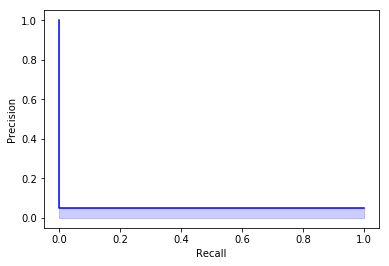

In [22]:

plt.step(recall, precision, color='b',
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')

In [23]:
def plot_figs(Y,label,indices):
    plt.figure()
    indices.loc[Y.index].plot()
    position = Y.index[np.where(Y==1)]
    for xc in position:
        plt.axvline(x=xc, color='r', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')

    plt.figure()
    indices.loc[Y.index].plot()
    label_position = Y.index[np.where(label==1)]
    for xc in label_position:
        plt.axvline(x=xc, color='b', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')
        
        
    plt.figure()
    indices.loc[Y.index].plot()
    matching_idx = np.intersect1d(np.where(label==1), np.where(Y==1))
    matching_position = Y.index[matching_idx]
    for xc in matching_position:
        plt.axvline(x=xc, color='g', linestyle='solid',linewidth=.55)


    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')

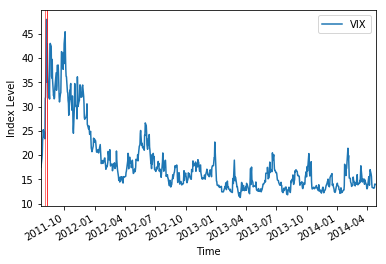

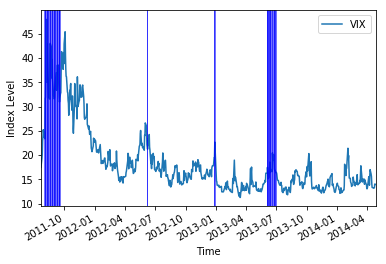

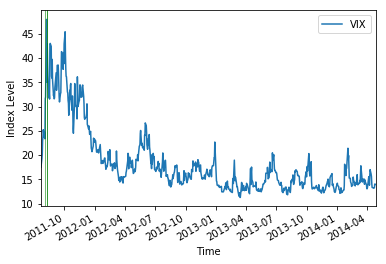

In [24]:
plot_figs(Y_val_df,predicted_classes,vix)

In [25]:
print(np.where(predicted_classes==1)) # Where our predictions said there were events
print(np.where(Y_val==1)) #Where there actually were events

(array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40, 220, 221, 359, 360, 361,
       467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 480,
       481, 482, 483, 484, 485, 486, 487]),)
(array([ 9, 11, 12]),)


# Integrated Gradients 1

Implementation adapted from example codegenerously given by the authors of the paper on their github
#Adjusted from https://github.com/ankurtaly/Integrated-Gradients/blob/master/attributions.ipynb


In [26]:
def T(layer,graph):
    #Helper for getting layer output tensor
    return graph.get_tensor_by_name(layer)

def scorer(sess,tensor,data):
      return sess.run(tensor, {'orig:0':data,is_training:False,K.learning_phase():0})
    
def top_label_and_score(data,graph):
    '''
    Returns the label and score of the object class
    that receives the highest SOFTMAX score.
    '''
    # Evaluate the SOFTMAX output layer for the image and
    # determine the label for the highest-scoring class
    t_softmax = tf.reduce_mean(T('dense_1/Sigmoid:0',graph), reduction_indices=0)
#     t_softmax = T('dense_3/Sigmoid:0',graph)
    scores = scorer(sess, t_softmax, data)
    id = np.argmax(scores)
    return labels[id], scores[id]

def output_label_tensor(label,graph):
    '''Returns a tensor (shape: scalar) representing the SOFTMAX
     for a given label.
    '''
    lab_index = np.where(np.in1d(Y_train, label))[0][0]
    lab_index = lab_index.astype(np.int32)
#     t_softmax = T('dense_3/Sigmoid:0',graph)
    t_softmax = tf.reduce_sum(T('dense_1/Sigmoid:0',graph), reduction_indices=0)

    return t_softmax[lab_index]

def integrated_gradients(data, label,graph, steps=10**6):
    '''
     Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided data.

    '''
    t_output = output_label_tensor(label,graph)  # shape: scalar
    t_grad = tf.gradients(t_output, T('orig:0',graph))[0]
    grads = scorer(sess, t_grad, data)
    return data*np.average(grads, axis=0)


Predict on X_train and get predictions from probas

In [27]:
proba_for_ig = my_model.predict(X_train)
pred_for_ig = proba_to_label(proba_for_ig,.50)

Get session and graph for Integrated Gradients

In [28]:
sess = K.get_session()
sess.run(tf.global_variables_initializer())


In [29]:
ig = integrated_gradients(X_train,pred_for_ig,sess.graph)

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


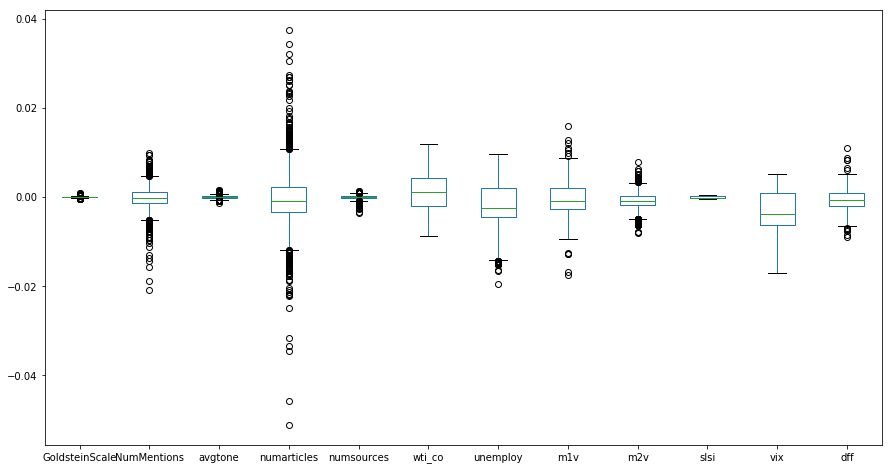

In [30]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
ig_df = pd.DataFrame(ig.reshape(-1,D))
ig_df.columns = X_train_df.columns
ig_df.plot.box()

### Results
Integrated Gradients reveal that the GDELT features are not contributing much at all

In [32]:
ig_df.mean().sort_values()

vix              -0.003054
unemploy         -0.001571
m2v              -0.001040
dff              -0.000722
m1v              -0.000597
numarticles      -0.000529
NumMentions      -0.000275
slsi             -0.000150
numsources       -0.000099
avgtone          -0.000062
GoldsteinScale   -0.000012
wti_co            0.000845
dtype: float32

In [33]:
np.abs(ig_df.mean()).sort_values()

GoldsteinScale    0.000012
avgtone           0.000062
numsources        0.000099
slsi              0.000150
NumMentions       0.000275
numarticles       0.000529
m1v               0.000597
dff               0.000722
wti_co            0.000845
m2v               0.001040
unemploy          0.001571
vix               0.003054
dtype: float32

## Integrated Gradients 2
#### https://github.com/hiranumn/IntegratedGradients/blob/master/IntegratedGradients.py

In [34]:
import IntegratedGradients as ig2 

In [35]:
int_grad = ig2.integrated_gradients(model=my_model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [36]:
int_grad_list = []
for i in range(len(X_train)):
    int_grad_list.append(int_grad.explain(X_train[i],num_steps=100).flatten())
    if i % 1000 == 0:
        print (i)

0
1000
2000
3000
4000
5000


In [38]:
feature_imp = pd.DataFrame(int_grad_list)
feature_imp.columns = X_train_df.columns


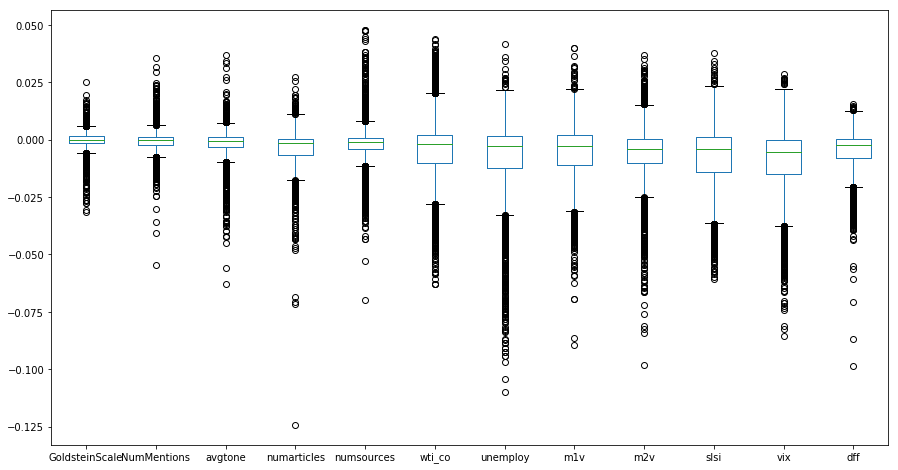

In [40]:
feature_imp.plot.box()

In [41]:
feature_imp.mean().sort_values()

vix              -0.008868
slsi             -0.006898
unemploy         -0.006466
m2v              -0.005605
m1v              -0.005488
dff              -0.004673
wti_co           -0.003726
numarticles      -0.003478
numsources       -0.001798
avgtone          -0.001441
NumMentions      -0.000556
GoldsteinScale   -0.000180
dtype: float64

In [42]:
np.abs(feature_imp.mean()).sort_values()

GoldsteinScale    0.000180
NumMentions       0.000556
avgtone           0.001441
numsources        0.001798
numarticles       0.003478
wti_co            0.003726
dff               0.004673
m1v               0.005488
m2v               0.005605
unemploy          0.006466
slsi              0.006898
vix               0.008868
dtype: float64

## Results 2

The other code reveals a similar story with regard to GDELT, as it's not a heavily contributing set of features. However the order of the financial features differs slightly from my implementation